# Finite Basis Kolmogorov-Arnold Networks (FBKANs) in Neuromancer

This tutorial demonstrates the use of Finite Basis Kolmogorov-Arnold Networks (FBKANs) to fit noisy 1D data.


### Kolmogorov-Arnold Networks (KANs)
KANs are neural networks inspired by the Kolmogorov-Arnold theorem, providing an alternative to traditional multilayer perceptrons (MLPs). KANs approximate multivariate functions by decomposing them into sums of nested univariate functions. Specifically, a KAN approximates a function $f(x)$ as:

$$
f(x) \approx \sum_{i_{nl-1}=1}^{m_{nl-1}} \phi_{nl-1, i_{nl-1}} \left( \cdots \sum_{i_1=1}^{m_1} \phi_{1, i_2, i_1} \left( \sum_{i_0=1}^{m_0} \phi_{0, i_1, i_0}(x_{i_0}) \right) \cdots \right)
$$

where $\phi_{j, i, k}$ are trainable, univariate activation functions represented by splines. This structure enables KANs to locally adjust function behavior with flexible resolution, making them effective for tasks with noisy data or where high interpretability is needed.


### Finite Basis Kolmogorov-Arnold Networks (FBKANs)
In FBKANs, KANs are enhanced through domain decomposition, a technique where the domain $\Omega$ is divided into overlapping subdomains $\Omega_j$. Each subdomain is managed by an independent KAN, and the outputs are blended together using a partition of unity function $\omega_j(x)$, forming an ensemble model:

$$
f(x) \approx \sum_{j=1}^{L} \omega_j(x) K_j(x; \theta_j)
$$

where $K_j(x; \theta_j)$ represents the KAN model specific to subdomain $\Omega_j$, and $\theta_j$ are the parameters for each KAN. The partition functions $\omega_j(x)$ ensure smooth transitions between subdomains, allowing FBKANs to handle complex, multiscale data effectively without additional boundary conditions. For a  comprehensive explanation of the architecture, we refer the user to [3].


<img src="../figs/fbkans_example.png" alt="FBKANs Example" width="60%"/>


### References

[1] [Liu, Ziming, et al. (2024). KAN: Kolmogorov-Arnold Networks.](https://arxiv.org/abs/2404.19756)

[2] https://github.com/Blealtan/efficient-kan

[3] [Howard, Amanda A., et al. (2024) Finite basis Kolmogorov-Arnold networks: domain decomposition for data-diven and physics-informed problems.](https://arxiv.org/abs/2406.19662)


### Install Neuromancer
(Note: You can skip this step if running locally.)
(Note 2: Colab might ask you to restart your session after installing Neuromancer. Simply restart it when prompted.)

In [1]:
# import os

# # Check if the neuromancer directory already exists
# if not os.path.isdir('neuromancer'):
#     # Clone the specific branch of the repository
#     !git clone --branch feature/fbkans https://github.com/pnnl/neuromancer.git

# # Navigate to the repository directory
# %cd neuromancer

# # Install the repository with the required extras
# !pip install -e .[docs,tests,examples]


### Import dependencies

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from neuromancer.dataset import DictDataset
from neuromancer.modules import blocks
from neuromancer.system import Node
from neuromancer.constraint import variable
from neuromancer.loss import PenaltyLoss
from neuromancer.problem import Problem
from neuromancer.trainer import Trainer
from neuromancer.loggers import LossLogger

import time


### Configure device and RNG seed

In [2]:
#Set default dtype to float32
torch.set_default_dtype(torch.float)
#PyTorch random number generator
torch.manual_seed(1234)
# Random number generators in other libraries
np.random.seed(1234)
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Generate data

We will use the function below to generate data from the function:

$$
f(x) = \exp\left[\sin\left(4 \pi x^2\right)\right],
$$

where $x \in [0,2]$. To simulate noise in the training data, random Gaussian noise with a standard deviation of 0.1 is added to the training labels.

In [3]:
def create_dataset(f,
                   n_var=2,
                   ranges = [0,1],
                   train_num=1000, 
                   test_num=1000,
                   normalize_input=False,
                   normalize_label=False,
                   device='cpu',
                   seed=0):
    '''
    create dataset
    
    Args:
    -----
        f : function
            the symbolic formula used to create the synthetic dataset
        ranges : list or np.array; shape (2,) or (n_var, 2)
            the range of input v|ariables. Default: [-1,1].
        train_num : int
            the number of training samples. Default: 1000.
        test_num : int
            the number of test samples. Default: 1000.
        normalize_input : bool
            If True, apply normalization to inputs. Default: False.
        normalize_label : bool
            If True, apply normalization to labels. Default: False.
        device : str
            device. Default: 'cpu'.
        seed : int
            random seed. Default: 0.
        
    Returns:
    --------
        dataset : dic
            Train/test inputs/labels are dataset['train_input'], dataset['train_label'],
                        dataset['test_input'], dataset['test_label']
         
    Example
    -------
    >>> f = lambda x: torch.exp(torch.sin(torch.pi*x[:,[0]]) + x[:,[1]]**2)
    >>> dataset = create_dataset(f, n_var=2, train_num=100)
    >>> dataset['train_input'].shape
    torch.Size([100, 2])
    '''

    np.random.seed(seed)
    torch.manual_seed(seed)

    if len(np.array(ranges).shape) == 1:
        ranges = np.array(ranges * n_var).reshape(n_var,2)
    else:
        ranges = np.array(ranges)
        
    train_input = torch.zeros(train_num, n_var)
    test_input = torch.zeros(test_num, n_var)
    for i in range(n_var):
        train_input[:,i] = torch.rand(train_num,)*(ranges[i,1]-ranges[i,0])+ranges[i,0]
        test_input[:,i] = torch.rand(test_num,)*(ranges[i,1]-ranges[i,0])+ranges[i,0]
        
    train_label = f(train_input)
    test_label = f(test_input)
        
    def normalize(data, mean, std):
            return (data-mean)/std
            
    if normalize_input == True:
        mean_input = torch.mean(train_input, dim=0, keepdim=True)
        std_input = torch.std(train_input, dim=0, keepdim=True)
        train_input = normalize(train_input, mean_input, std_input)
        test_input = normalize(test_input, mean_input, std_input)
        
    if normalize_label == True:
        mean_label = torch.mean(train_label, dim=0, keepdim=True)
        std_label = torch.std(train_label, dim=0, keepdim=True)
        train_label = normalize(train_label, mean_label, std_label)
        test_label = normalize(test_label, mean_label, std_label)

    dataset = {}
    dataset['train_input'] = train_input.to(device)
    dataset['test_input'] = test_input.to(device)

    dataset['train_label'] = train_label.to(device)
    dataset['test_label'] = test_label.to(device)

    return dataset


In [4]:
# Function to sample from
f = lambda x: torch.exp((torch.sin(4*torch.pi*(x[:,[0]]**2))))

# Create dataset
dataset = create_dataset(f, n_var=1, ranges=[0,2], train_num=400, test_num=1000, device=device)

# Extract data directly as PyTorch tensors
X_train = dataset['train_input']
X_test = dataset['test_input']
y_train = dataset['train_label']
y_test = dataset['test_label']
y_clean = y_train.clone()

# Add noise to y_train
y_train += 0.1 * torch.randn_like(y_train)


In [5]:
# Wrap data into Neuromancer DictDatasets
train_data = DictDataset({'x': dataset['train_input'].to(device), 'y':dataset['train_label'].to(device)}, name='train')
dev_data = DictDataset({'x': dataset['test_input'].to(device), 'y':dataset['test_label'].to(device)}, name='dev')

# Create torch dataloaders with DictDatasets
batch_size = train_data.datadict['x'].shape[0]
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                           collate_fn=train_data.collate_fn,
                                           shuffle=False)
dev_loader = torch.utils.data.DataLoader(dev_data, batch_size=batch_size,
                                         collate_fn=dev_data.collate_fn,
                                         shuffle=False)

### Create KAN blocks in Neuromancer

We now instantiate a `KANBlock` in Neuromancer. The `KANBlock` allows for the configuration of Kolmogorov-Arnold Networks (KANs) with domain decomposition via the argument `num_domains`. Note that `num_domains=1` by default, but we highlight it when defining `net_kan` for clarity.


- **`insize`**: *(int)* – The size of the input features for each KAN layer in the block. In this case, since the input $x$ is 1D, `insize=1`.

- **`outsize`**: *(int)* – The size of the output features for each KAN layer in the block. Since the output is the function $f(x)$, (1D), `outsize=1`.

- **`hsizes`**: *(list[int])* – A list defining the size of each hidden layer. For example, `hsizes=[5]` creates a single hidden layer with 5 neurons.

- **`num_domains`**: *(int)* – The number of subdomains, each with its own KAN network layers.

- **`spline_order`**: *(int)* – Specifies the order of the B-spline basis functions. Higher orders allow for more expressivity, as it increases the number of trainable parameters.

- **`grid_range`**: *(list[float])* - Defines the range of the grids. Default is [-1., 1.].


In [ ]:
# Neural nets to solve the PDE problem
net_fbkan = blocks.KANBlock(insize=1,
                            outsize=1,
                            hsizes=[5], # hidden width
                            num_domains=10, # number of domains for domain decomposition
                            spline_order=3, # spline order
                            grid_range=[0.,2.] # range of the grids
                            ).to(device)


net_kan = blocks.KANBlock(insize=1,
                          outsize=1,
                          hsizes=[5], # hidden width
                          num_domains=1,  # number of domains
                          grid_sizes=[5], # grid size for KAN
                          spline_order=3, # spline order
                          grid_range=[0.,2.] # range of the grids
                          ).to(device)

# Symbolic wrapper of the neural nets
neural_net_wrapper_fbkan = Node(net_fbkan, ['x'], ['y_hat'], name='net_wrapper_fbkan')
neural_net_wrapper_kan = Node(net_kan, ['x'], ['y_hat'], name='net_wrapper_kan')


### Define Symbolic Variables and Losses in Neuromancer

In this experiment, we compare the performance of Kolmogorov-Arnold Networks (KANs) and Finite Basis Kolmogorov-Arnold Networks (FBKANs) by defining separate data loss functions for each. The goal for both models is to minimize the error between the predicted values, $\hat{f}(x) =$ `y_hat`, and the true target values, $f(x) =$ `y`, across the dataset.

**Symbolic Variables:**

- `x`: Input variable, where $x \in [0, 2]$.
- `y`: True target values from the function $f(x)$.
- `y_hat`: Predicted values produced by either the KAN or FBKAN model.

**Data Loss for FBKAN:**

The data loss for FBKAN, denoted as `loss_data_fbkan`, measures the mean squared error (MSE) between the FBKAN predictions, `y_hat`, and the true values, `y`:

$$
\ell_{\text{data, FBKAN}} = \text{scaling} \cdot \frac{1}{N_{\text{data}}} \sum_{i=1}^{N_{\text{data}}} \left( y_i - y_{\text{hat, FBKAN}} \right)^2
$$

This loss guides the FBKAN model to approximate the target function values accurately.

**Data Loss for KAN:**

Similarly, the data loss for KAN, denoted as `loss_data_kan`, is the mean squared error between the KAN predictions, `y_hat`, and the true target values, `y`:

$$
\ell_{\text{data, KAN}} = \text{scaling} \cdot \frac{1}{N_{\text{data}}} \sum_{i=1}^{N_{\text{data}}} \left( y_i - y_{\text{hat, KAN}} \right)^2
$$

This loss term helps the KAN model learn to approximate the target function.

**Combined Loss Functions:**

Each model’s loss function is then constructed with a `PenaltyLoss`:

- **`loss_fbkan`**: Defined for the FBKAN model, using `loss_data_fbkan`.
- **`loss_kan`**: Defined for the KAN model, using `loss_data_kan`.

In this case, we have left the problem unconstrainted. However, constraints can be added via the `constraints` argument.

These loss functions are minimized separately for each model, enabling a direct comparison of FBKAN and KAN performance on the same data.


In [ ]:
# Define symbolic variables in Neuromancer
# Note: y = f(x)
x = variable('x')
y = variable('y')
y_hat = variable('y_hat')

scaling = 1.

loss_data_fbkan = (y == y_hat)^2
loss_data_fbkan.name = "ref_loss_fbkan"

loss_data_kan = (y == y_hat)^2
loss_data_kan.name = "ref_loss_kan"

loss_fbkan = PenaltyLoss(objectives=[loss_data_fbkan], constraints=[])
loss_kan = PenaltyLoss(objectives=[loss_data_kan], constraints=[])


### Construct the Neuromancer Problem objects and train

In [8]:
# Construct the optimization problems
problem_fbkan = Problem(nodes=[neural_net_wrapper_fbkan],          # list of nodes (neural nets) to be optimized
                  loss=loss_fbkan,                                 # data loss
                  grad_inference=True                              # argument for allowing computation of gradients at the inference time
                 )

problem_kan = Problem(nodes=[neural_net_wrapper_kan],              # list of nodes (neural nets) to be optimized
                  loss=loss_kan,                                   # data loss
                  grad_inference=True                              # argument for allowing computation of gradients at the inference time
                 )

In [9]:
# Parameters for training
num_epochs = 2000
epoch_verbose = 50

# Initial learning rate
init_lr = 1e-2

# Create loggers
logger_fbkan = LossLogger(args=None, savedir='test_fbkan', verbosity=epoch_verbose, stdout=['train_loss','dev_loss'])
logger_kan = LossLogger(args=None, savedir='test_kan', verbosity=epoch_verbose, stdout=['train_loss', 'dev_loss'])

# Create trainers
trainer_fbkan = Trainer(
    problem_fbkan.to(device),
    train_data=train_loader,
    dev_data=dev_loader,
    optimizer= torch.optim.Adam(problem_fbkan.parameters(), lr=init_lr),
    epoch_verbose=epoch_verbose,
    logger=logger_fbkan,
    epochs=num_epochs,
    train_metric='train_loss',
    eval_metric='dev_loss',
    dev_metric='dev_loss',
    warmup=num_epochs,
    device=device
)

trainer_kan = Trainer(
    problem_kan.to(device),
    train_data=train_loader,
    dev_data=dev_loader,
    optimizer= torch.optim.Adam(problem_kan.parameters(), lr=init_lr),
    epoch_verbose=epoch_verbose,
    logger=logger_kan,
    epochs=num_epochs,
    train_metric='train_loss',
    eval_metric='dev_loss',
    dev_metric='dev_loss',
    warmup=num_epochs,
    device=device
)



Number of parameters: 1000
Number of parameters: 100


In [10]:
# Train KAN
start_time = time.time()

best_model_kan = trainer_kan.train()
problem_kan.load_state_dict(best_model_kan)
trained_model_kan = problem_kan.nodes[0]
y_test_pred_kan = trained_model_kan(dev_data.datadict)['y_hat'].cpu().detach().numpy()

print(f'Elapsed time = {time.time()-start_time}')

epoch: 0	train_loss: 2.72812	dev_loss: 2.43958	eltime:  0.03616
epoch: 50	train_loss: 0.69293	dev_loss: 0.67429	eltime:  0.40859
epoch: 100	train_loss: 0.63379	dev_loss: 0.61552	eltime:  0.73413
epoch: 150	train_loss: 0.54580	dev_loss: 0.51654	eltime:  1.09647
epoch: 200	train_loss: 0.47687	dev_loss: 0.47113	eltime:  1.37962
epoch: 250	train_loss: 0.43037	dev_loss: 0.42795	eltime:  1.67505
epoch: 300	train_loss: 0.34899	dev_loss: 0.35744	eltime:  2.01962
epoch: 350	train_loss: 0.25711	dev_loss: 0.23473	eltime:  2.44207
epoch: 400	train_loss: 0.14942	dev_loss: 0.14594	eltime:  2.91074
epoch: 450	train_loss: 0.11961	dev_loss: 0.12998	eltime:  3.31423
epoch: 500	train_loss: 0.09109	dev_loss: 0.10154	eltime:  3.69886
epoch: 550	train_loss: 0.07658	dev_loss: 0.08560	eltime:  4.06116
epoch: 600	train_loss: 0.06664	dev_loss: 0.07253	eltime:  4.43047
epoch: 650	train_loss: 0.05640	dev_loss: 0.05513	eltime:  4.83353
epoch: 700	train_loss: 0.04705	dev_loss: 0.04137	eltime:  5.31185
epoch: 750	tr

In [11]:
# Train FBKAN
start_time = time.time()

best_model_fbkan = trainer_fbkan.train()
problem_fbkan.load_state_dict(best_model_fbkan)
trained_model_fbkan = problem_fbkan.nodes[0]
y_test_pred_fbkan = trained_model_fbkan(dev_data.datadict)['y_hat'].cpu().detach().numpy()
print(f'Elapsed time = {time.time()-start_time}')

epoch: 0	train_loss: 2.78375	dev_loss: 2.51061	eltime:  14.52040
epoch: 50	train_loss: 0.59925	dev_loss: 0.55923	eltime:  16.43538
epoch: 100	train_loss: 0.31653	dev_loss: 0.32432	eltime:  18.50102
epoch: 150	train_loss: 0.18461	dev_loss: 0.19397	eltime:  20.48488
epoch: 200	train_loss: 0.05953	dev_loss: 0.05293	eltime:  22.70340
epoch: 250	train_loss: 0.01788	dev_loss: 0.01243	eltime:  24.50923
epoch: 300	train_loss: 0.01205	dev_loss: 0.00835	eltime:  26.59553
epoch: 350	train_loss: 0.01116	dev_loss: 0.00787	eltime:  28.56603
epoch: 400	train_loss: 0.01051	dev_loss: 0.00744	eltime:  31.14397
epoch: 450	train_loss: 0.00984	dev_loss: 0.00729	eltime:  33.12374
epoch: 500	train_loss: 0.00911	dev_loss: 0.00694	eltime:  35.03787
epoch: 550	train_loss: 0.00861	dev_loss: 0.00687	eltime:  36.63918
epoch: 600	train_loss: 0.00827	dev_loss: 0.00673	eltime:  38.70901
epoch: 650	train_loss: 0.00812	dev_loss: 0.00672	eltime:  40.98340
epoch: 700	train_loss: 0.00808	dev_loss: 0.00694	eltime:  42.6714

### Plot results

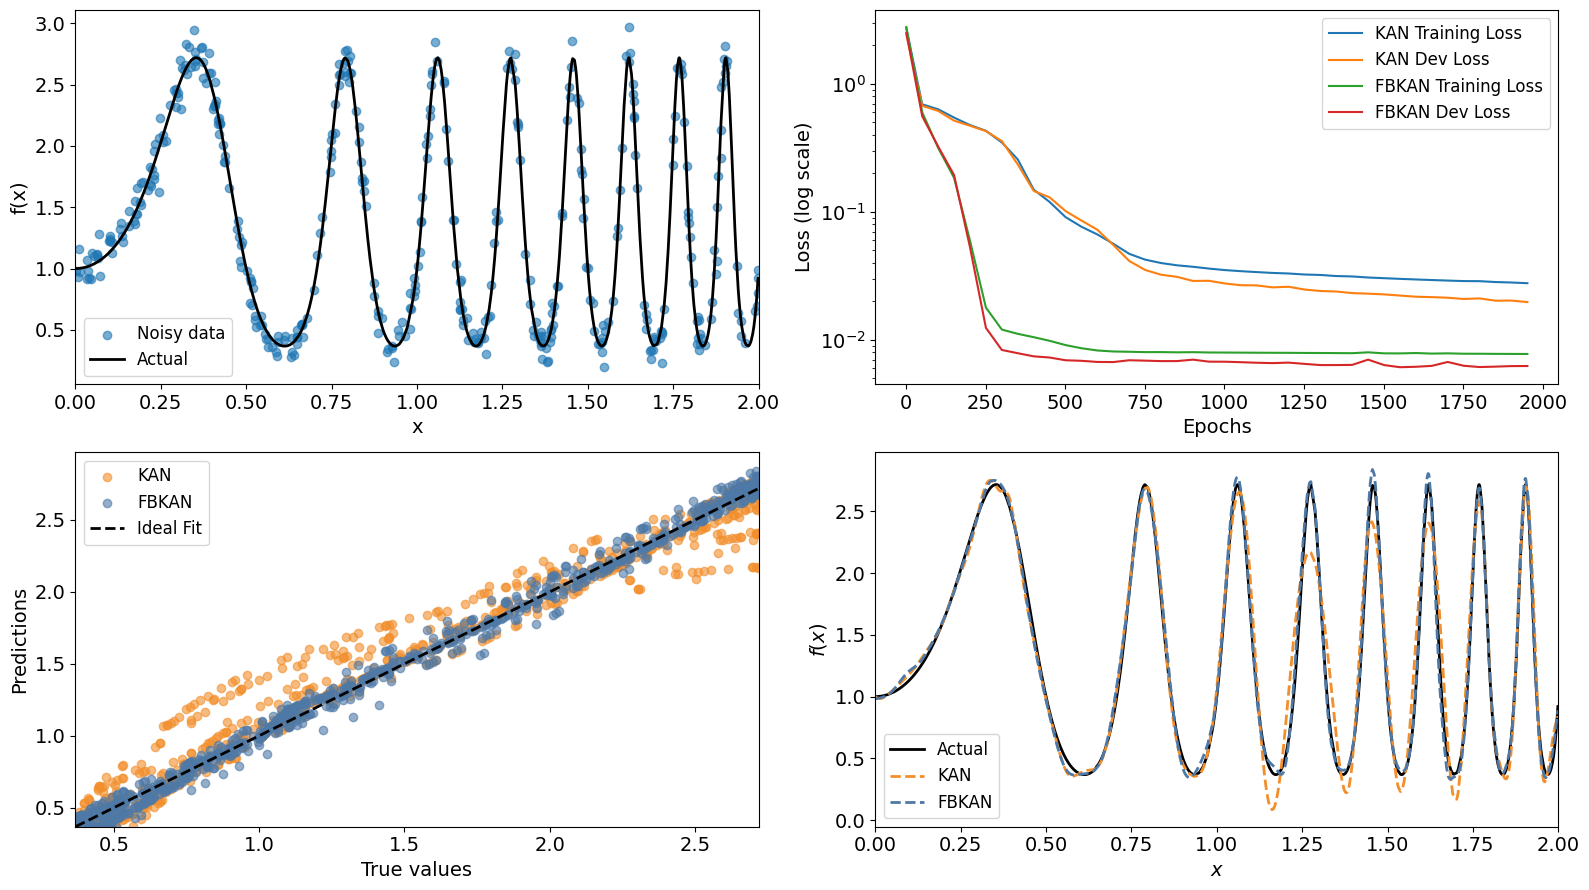

In [13]:
# Plotting
fig, ax = plt.subplots(2, 2, figsize=(16, 9))
losses_fbkan = trainer_fbkan.logger.get_losses()
losses_kan = trainer_kan.logger.get_losses()
sorted_indices = np.argsort(X_test[:, 0].numpy(), axis=0)
X_test_sorted = X_test[sorted_indices]
y_test_sorted = y_test[sorted_indices]
y_test_pred_fbkan_sorted = y_test_pred_fbkan[sorted_indices]
y_test_pred_kan_sorted = y_test_pred_kan[sorted_indices]

# Plotting losses vs epochs with log scale on y-axis
epochs = range(1, len(losses_fbkan['train'])*epoch_verbose+1, epoch_verbose)

# Sorting the training data for plotting noisy data and clean function
inds = np.argsort(X_train[:, 0].numpy(), axis=0)
X_train_sorted = X_train[inds]
y_train_sorted = y_train[inds]

# Plotting noisy data and clean function
ax[0, 0].scatter(X_train_sorted[:, 0], y_train_sorted[:, 0], label='Noisy data', alpha=0.6)
ax[0, 0].plot(X_test_sorted[:, 0], y_test_sorted[:, 0], 'k', label='Actual', linewidth=2)
ax[0, 0].set_xlim([0, 2])
ax[0, 0].set_xlabel('x', fontsize=14)
ax[0, 0].set_ylabel(r'f(x)', fontsize=14)
ax[0, 0].legend(fontsize=12, ncol=1)
ax[0, 0].tick_params(labelsize=14)

# Plotting loss vs epochs
ax[0, 1].plot(epochs, losses_kan['train'], label='KAN Training Loss')
ax[0, 1].plot(epochs, losses_kan['dev'], label='KAN Dev Loss')
ax[0, 1].plot(epochs, losses_fbkan['train'], label='FBKAN Training Loss')
ax[0, 1].plot(epochs, losses_fbkan['dev'], label='FBKAN Dev Loss')
ax[0, 1].set_xlabel('Epochs', fontsize=14)
ax[0, 1].set_ylabel('Loss (log scale)', fontsize=14)
ax[0, 1].set_yscale('log')
ax[0, 1].legend(fontsize=12, ncol=1)
ax[0, 1].tick_params(labelsize=14)

# Plotting predictions vs true values
ax[1, 0].scatter(y_test_sorted, y_test_pred_kan_sorted, label='KAN', alpha=0.6, color='#f28e2b')
ax[1, 0].scatter(y_test_sorted, y_test_pred_fbkan_sorted, label='FBKAN', alpha=0.6, color='#4e79a7')
ax[1, 0].plot([y_test_sorted.min(), y_test_sorted.max()], [y_test_sorted.min(), y_test_sorted.max()], 'k--', lw=2, label='Ideal Fit')
ax[1, 0].set_xlim([y_test_sorted.min(), y_test_sorted.max()])
ax[1, 0].set_ylim([y_test_sorted.min(), y_test_sorted.max() + 0.25])
ax[1, 0].set_xlabel('True values', fontsize=14)
ax[1, 0].set_ylabel('Predictions', fontsize=14)
ax[1, 0].legend(fontsize=12, ncol=1)
ax[1, 0].tick_params(labelsize=14)

# Plotting function approximation
ax[1, 1].plot(X_test_sorted[:, 0], y_test_sorted[:, 0], 'k-', label='Actual', linewidth=2)
ax[1, 1].plot(X_test_sorted[:, 0], y_test_pred_kan_sorted[:, 0], '--', color='#f28e2b', label='KAN', linewidth=2)
ax[1, 1].plot(X_test_sorted[:, 0], y_test_pred_fbkan_sorted[:, 0], '--', color='#4e79a7', label='FBKAN', linewidth=2)
ax[1, 1].set_xlim([0, 2])
ax[1, 1].legend(fontsize=12, ncol=1)
ax[1, 1].tick_params(labelsize=14)
ax[1, 1].set_xlabel('$x$', fontsize=14)
ax[1, 1].set_ylabel('$f(x)$', fontsize=14)

plt.tight_layout()
plt.show()